# Leaky Integration
As already described in the <a target="_blank" rel="noopener" href="https://recurrence-reviewed.de/neuron-models">Introduction to Neuron Models</a>, the current state $x$ of a neuron $i$ not only depends on the inputs $U$ from the pre-synaptic layer $j$ but also on previous activations $\theta$. This is because a neuron does not respond instantaneously to new inputs. This can be addressed by modelling a neuron as leaky integrator.  

Recalling our neuron model form the introduction, we use the following equation to model one neuron:  
\begin{align}
x_i &= W_{i,j} \cdot U_j
\end{align}

As we now introduce a previous activation, we need to introduce time. To model discrete neuron states we can formulate the next state of our neuron at $t+1$ as:

\begin{align}
x_i(t+1) &= W_{i,j} \cdot U_j(t)
\end{align}

To include the previous activation $\theta_i(t)$ we need to somehow define how much the next state $x_i(t+1)$ depends on the current inputs $U_j(t)$ and how much it depends on the previous activation $\theta_i(t)$. We do so by introducing a leak-rate $\lambda_i$ for our neuron. This leak-rate defines ho much of the current activation fades till the next state. If the leak-rate is $0$, the next state solely depends on the current activation, if the leak-rate is $1$ the next state solely depends on the current inputs.

<p style="text-align:center;font-size:80%;font-style:italic">
    <img src="./Figures/leaky_integration.svg"></a>
    <br>
    Figure 1: Symbolic representation of leaky integration.
</p>

So we can re-formulate our neuron state equation as:

\begin{align}
x_i(t+1) &= \lambda_i \cdot \left(W_{i,j} \cdot U_j(t)\right) + (1-\lambda_i) \cdot \theta_i(t)
\end{align}

Let's see how this affects the dynamic of one neuron by modelling it in python. We use the class for a single neuron, previously defined in the introduction and extend it by the leaking rate in line 9 and 14 (we cannot use lambda here as this is reserved for lambda expressions in python):

In [3]:
import numpy as np

class single_neuron_leaky:

    def __init__(self, n_inputs: int, leak_rate: float,  seed: int = 42):
        np.random.seed(seed)
        self.x = 0
        self.theta = 0
        self.leak = leak_rate
        self.u = np.zeros([n_inputs, 1])
        self.w = np.random.uniform(low=-1, high=1, size=[1, n_inputs])

    def activate(self, input_vector):
        self.x = self.leak*np.dot(self.w, input_vector) + (1-self.leak)*self.theta
        self.theta = np.tanh(self.x)

    def step(self, input_vector):
        self.activate(input_vector)
        return self.theta

We now use only one input with zeros and a step of magnitude $1$ for time-steps $5$ to $10$ (lines 4-5). We also set the weight for this input to $1$ (line 14) and calculate the output for $30$ steps (line 1) and leak-rates from $1$ to $0$ in steps of $0.2$ (line 9).

In [4]:
length = 30

# set th einput at t=5 to 1
u = np.zeros(length)
u[5:10] = 1

# testing leak rates from 1 to 0 in
# steps of 0.2
leak_rates = [1, 0.8, 0.6, 0.4, 0.2, 0]
o = np.zeros([len(leak_rates), length])

for n, lr in enumerate(leak_rates):
    neuron = single_neuron_leaky(1, lr)
    neuron.w = np.ones(1)
    for i in range(length):
        o[n, i] = neuron.step(u[i])

Text(0.5, 0, '$t$')

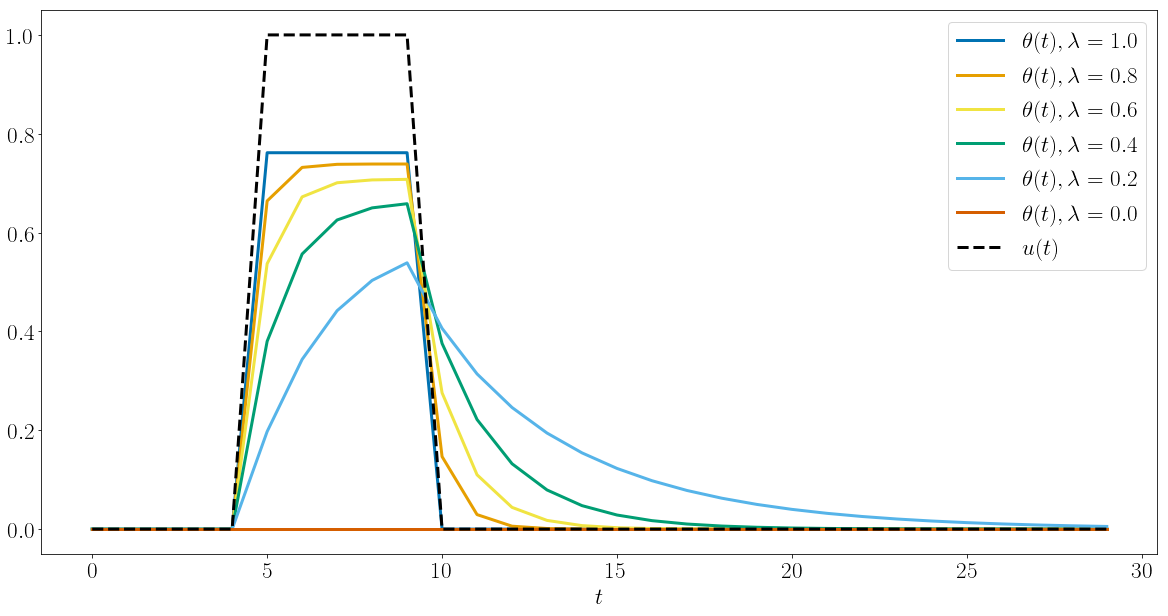

In [6]:
from matplotlib import pyplot as plt
from matplotlib import rc

# Set plot parameters
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Latin Modern Sans']})
params = {'font.size': 16,
          'figure.figsize': [20, 10],
          'text.usetex': True,
          'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# plot the stuff
colors = ['#0072b2', '#e69f00', '#f0e442', '#009e73', '#56b4e9', '#d55e00', '#cc79a7', '#000000']
fig, ax = plt.subplots()
for n, lr in enumerate(leak_rates):
    ax.plot(o[n,:], color=colors[n], linewidth=3, label=r"$\theta(t), \lambda = %.1f $" % lr)
ax.plot(u, color='black', linewidth=3, linestyle='dashed', label=r"$u(t)$")
   
ax.legend()
ax.set_xlabel(r"$t$")

Here we can recognise how the neuron responds directly to the input for a leak-rate of 1, while this response gets slower and slower for lower leak-rates. We can now continue to extend this model for one neuron to a whole layer of neurons.

As each neuron has unique properties, we also need to introduce unique leak-rates for each neuron within a modelled layer of neurons. We can do so by formulating these leak-rates as a square-matrix $\Lambda$ (capital $\lambda$): On the main-diagonal of this square matrix we put the leak-rates for the neurons. All other elements are $0$. Let's note this down in detail in a small example with three inputs $U$ and two neurons:

\begin{align}
    X(t+1) &= \Lambda \cdot \left(W \cdot U(t)\right) + (I-\Lambda) \cdot \Theta(t) \\
           &=\Lambda \cdot \left(
    \begin{bmatrix}
        w_{1,1} & w_{1,2} & w_{1,3} \\
        w_{2,1} & w_{2,2} & w_{2,3}
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        u_1 \\
        u_2 \\
        u_3
    \end{bmatrix}
    \right) + (I-\Lambda) \cdot \Theta(t) \\
    &=
    \begin{bmatrix}
        \lambda_1 & 0 \\
        0 & \lambda_2
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        w_{1,1} u_1 + w_{1,2} u_2 + w_{1,3} u_3 \\
        w_{2,1} u_1 + w_{2,2} u_2 + w_{2,3} u_3
    \end{bmatrix}
    +
    \begin{bmatrix}
        1-\lambda_1 & 0 \\
        0 & 1-\lambda_2
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        \theta_1(t) \\
        \theta_2(t)
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
        \lambda_1 \cdot (w_{1,1} u_1 + w_{1,2} u_2 + w_{1,3} u_3) \\
        \lambda_2 \cdot (w_{2,1} u_1 + w_{2,2} u_2 + w_{2,3} u_3)
    \end{bmatrix}
    +
    \begin{bmatrix}
        (1-\lambda_1) \cdot \theta_1(t) + 0 \cdot \theta_2(t) \\
        0 \cdot \theta_1(t) + (1-\lambda_2) \cdot \theta_2(t)
    \end{bmatrix}
\end{align}

Using this matrix notation, we can still use the dot-product for calculation, which is a benefit when it comes to programming and it has other advantages as we will see later. But first let's change our class for one neuron layer, to add leaky integration:

First we add a random initialised leak matrix by using the numpy `diag` function (line 9). As we do not want to calculate $I - \Lambda$ on every time-step, we calculate the recurrent leak also on initialisation (line 10). To set custom leak rates we also add a `set_leak` function which takes a numpy array of leak rates as input:

In [7]:
class layer_leaky:

    def __init__(self, n_inputs: int, n_outputs: int, seed: int = 42):
        np.random.seed(seed)
        self.x = np.zeros([n_outputs, 1])
        self.theta = np.zeros([n_outputs, 1])
        self.u = np.zeros([n_inputs, 1])
        self.w = np.random.uniform(low=-1, high=1, size=[n_outputs, n_inputs])
        self.leak = np.diag(np.random.uniform(low=0, high=1, size=n_outputs))
        self.leak_rec = np.identity(n_outputs)-self.leak

    def set_leak(self, leak_rates: np.array):
        n_outputs = self.x.shape[0]
        self.leak = np.diag(leak_rates)
        self.leak_rec = np.identity(n_outputs)-self.leak
        
    def activate(self, input_vector):
        self.x = np.dot(self.leak, np.dot(self.w, input_vector)) + np.dot(self.leak_rec, self.theta)
        self.theta = np.tanh(self.x)

    def step(self, input_vector):
        self.activate(input_vector)
        return self.theta

We use the same three inputs for two neurons as in the previous post. To compare the behaviour of this neuron layer, we initialise one layer with random leak-rates (line 15) and one layer with a leak rate of $1$ (lines 16-17), thereby creating the equivalent to a layer without leak:

In [8]:
# number of time-steps
length = 400

# inputs to the network as different sine waves
u0 = np.sin((np.arange(length) * np.pi / 10) + np.pi / 2)
u1 = 0.8*np.sin((np.arange(length) * np.pi / 15) + np.pi / 4)
u2 = 0.5*np.sin((np.arange(length) * np.pi / 20) + np.pi)

# stack the three inputs, so each row is the input for one time-step
u = np.stack([u0, u1, u2], axis=0)

o_1 = np.zeros([2, length])
o_2 = np.zeros([2, length])

neurons_1 = layer_leaky(3,2)
neurons_2 = layer_leaky(3,2)
neurons_2.set_leak(np.ones(2))

for i in range(length):
    o_1[:,i:i+1] = neurons_1.step(u[:,i:i+1])
    o_2[:,i:i+1] = neurons_2.step(u[:,i:i+1])

Text(0.5, 0, 'time-steps')

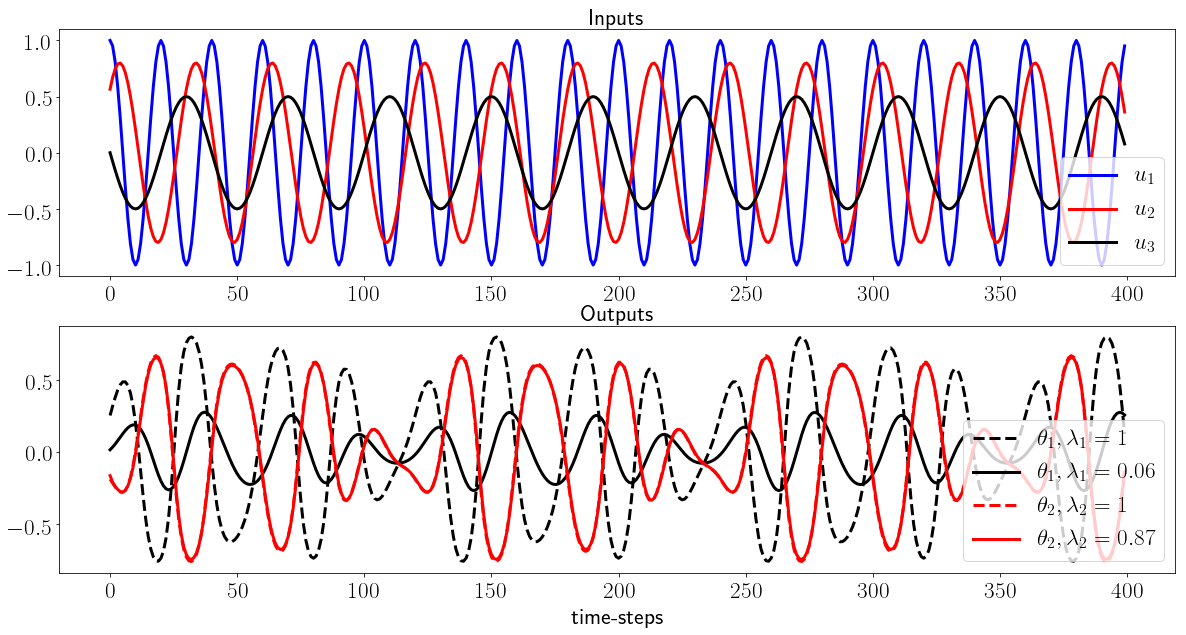

In [9]:
# plot the stuff
fig, axes = plt.subplots(2, 1)
axes[0].set_title(r"Inputs")
axes[0].plot(u0, color="blue", linewidth=3, label=r"$u_1$")
axes[0].plot(u1, color="red", linewidth=3, label=r"$u_2$")
axes[0].plot(u2, color="black", linewidth=3, label=r"$u_3$")
axes[0].legend()
axes[1].set_title(r"Outputs")
axes[1].plot(o_2[0,:], color="black", linewidth=3, linestyle="dashed", label=r"$\theta_1, \lambda_1=1$")
axes[1].plot(o_1[0,:], color="black", linewidth=3, label=r"$\theta_1, \lambda_1=%.2f$" % neurons_1.leak[0,0])
axes[1].plot(o_2[1,:], color="red", linewidth=3, linestyle="dashed", label=r"$\theta_2, \lambda_2=1$")
axes[1].plot(o_1[1,:], color="red", linewidth=3, label=r"$\theta_2, \lambda_2=%.2f$" % neurons_1.leak[1,1])
axes[1].legend(loc=4)
axes[1].set_xlabel(r"time-steps")

The resulting output shows how the first neuron with a leak-rate far below $1$ ($0.06$) exhibits completely different dynamics compared to the previous configuration with a leak of $1$ (black). The second neuron with a leak-rate close to $1$ ($0.87$) expectedly shows almost the same behaviour as with a leak-rate of $1$ (red). Here we can observe how the leak-rate controls the dynamics of the neuron and speeds it up for high leak-rates and slows it down for small leak-rates. We can envision this property as simple low-pass filters:

To test the filter properties of leaky-integrating neurons, we can use a chirp from a high to a low frequency (from `scipy.signal.chirp`). The output of the neuron then tells us at which frequncy it responds for the given leak rate. Hence, we create a chirp from $100$ to $1$ $Hz$ in $1000$ steps for one second (lines 5-6) and test the response for lower leak rates (line 8):

In [88]:
from scipy.signal import chirp

length= 1001

t = np.linspace(0, 1, length)
u = chirp(t, f0=100, f1=1, t1=1, method='linear')

leak_rates = [0.6, 0.4, 0.2, 0.1, 0.05, 0.02]
o = np.zeros([len(leak_rates), length])

for n, lr in enumerate(leak_rates):
    neuron = single_neuron_leaky(1, lr)
    neuron.w = np.ones(1)
    for i in range(length):
        o[n, i] = neuron.step(u[i])

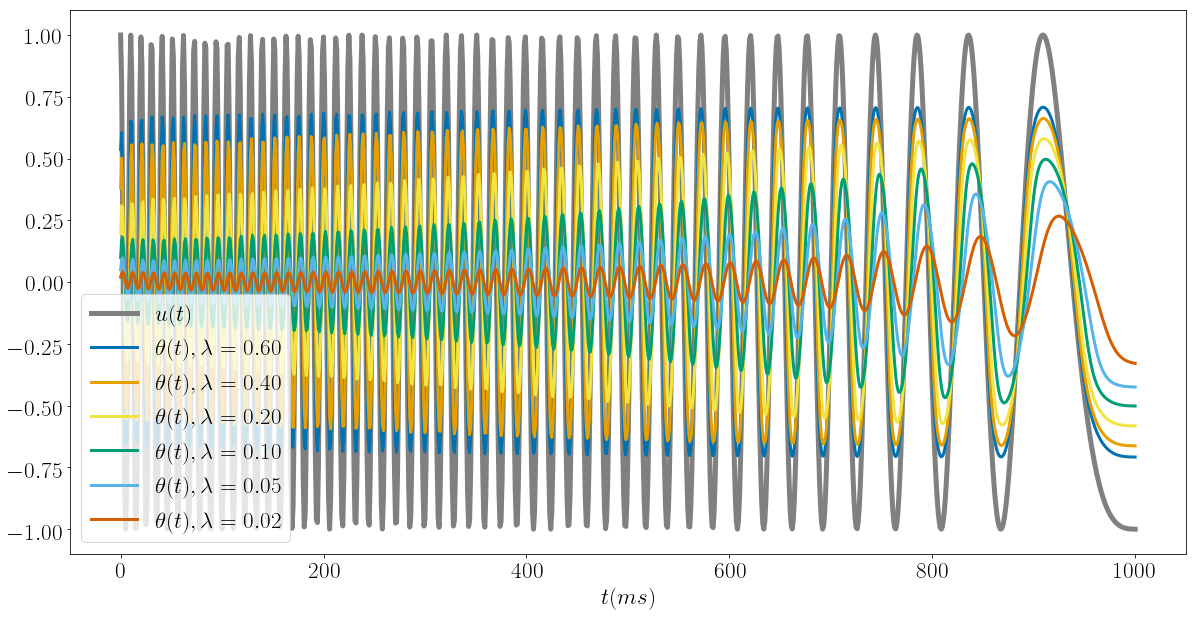

In [90]:
# Set plot parameters
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Latin Modern Sans']})
params = {'font.size': 16,
          'figure.figsize': [20, 10],
          'text.usetex': True,
          'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# plot the stuff
colors = ['#0072b2', '#e69f00', '#f0e442', '#009e73', '#56b4e9', '#d55e00', '#cc79a7', '#000000']
fig, ax = plt.subplots()
ax.plot(u, color='gray', linewidth=5, label=r"$u(t)$")
for n, lr in enumerate(leak_rates):
    scale = 1 # np.max([np.abs(np.min(o[n,:])), np.max(o[n,:])])
    ax.plot(o[n,:]/scale, color=colors[n], linewidth=3, label=r"$\theta(t), \lambda = %.2f $" % lr)
   
ax.legend()
ax.set_xlabel(r"$t (ms)$")

This shows us how a neuron with a leak-rate of $0.6$ responds with almost a constant amplitude to the chirp, while neurons with lower leak rates start to respond later.

At the end of this post I want to make another remark on why we modelled the leak rate as a matrix instead of a vector:  
In the second half of our layer state-equation we use activations of other neurons $\Theta(t)$ to calculate the future states. As all other elements than the main-diagonal of the leak-rate matrix are zero, we only include the activation $\theta_i$ of one neuron in its own state update but not in the state update of other neurons. Setting the elements outside the main diagonal different from zero woul e.g. include $\theta_2$ in the state update of neuron $1$. This enables us to model recurrent connections as we will see in the next posts.